# Cosine scheduler, revisited

> In this module, we approach a classic AI art algorithm

In [1]:
#| default_exp cos_revisited

In [2]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import lr_scheduler
from tqdm import tqdm

from slowai.ddpm import fashion_unet, get_dls
from slowai.learner import (
    Callback,
    DeviceCB,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    after,
    def_device,
    only,
)
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_images

In [3]:
plt.style.use("ggplot")

Often in diffusion, we refer to time steps like so

```python
T = 1000
for t in range(T):
    print(f"Progress: {t/T}")
```

Jeremy notes that we can simply use a progress variable $\in [0, 1]$. This allows us to simplify the $\bar{\alpha}$ expression like so:

In [4]:
def ᾱ(t):
    assert (0 <= t).all() and (t <= 1).all()
    return ((t * math.pi / 2).cos() ** 2).clamp(0.0, 0.999)

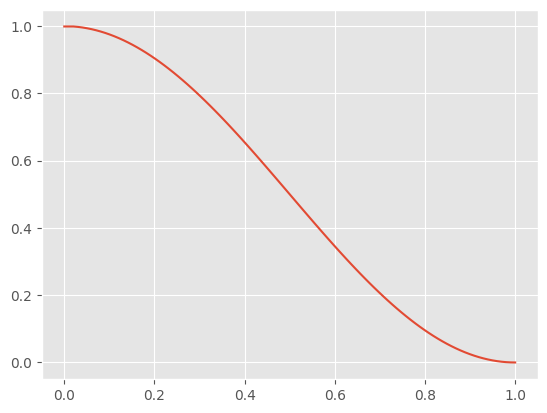

In [5]:
x = torch.linspace(0, 1, 100)
plt.plot(x, ᾱ(x));

And, furthermore, the noisify function can be simplified like so:

In [6]:
def noisify(x_0, t=None):
    n, *_ = x_0.shape
    device = x_0.device

    if t is None:
        t = torch.rand((n,), device=device)

    # Sample 2D noise for each example in the batch
    ε = torch.randn(x_0.shape, device=device)

    # Add noise according to the equation in Algorithm 1, such
    # that the variance of the distribution does not change
    ᾱ_t = ᾱ(t).reshape(-1, 1, 1, 1).to(device)
    x_t = ᾱ_t.sqrt() * x_0 + (1 - ᾱ_t).sqrt() * ε

    return ((x_t, t), ε)

Now, (a) we don't have to deal with knowing the time steps, computing $\alpha$ and $\beta$ and (b) the process is continuous.

Let's add this to the DDPM training callback. Notice that the constructor has been deleted.

In [7]:
class DDPM(Callback, order=after(DeviceCB)):
    def before_batch(self, learn):
        x_0, _ = learn.batch
        learn.batch = noisify(x_0)

    @only
    def predict(self, learn):
        (x_t, t), _ = learn.batch
        learn.preds = learn.model(x_t, t).sample

In [8]:
def train(
    model,
    lr=4e-3,
    n_epochs=2,
    bs=128,
    opt_func=torch.optim.Adam,
    extra_cbs=[],
    ddpm=DDPM(),
):
    dls = get_dls(bs)
    T_max = len(dls["train"]) * n_epochs
    cbs = [
        ddpm,
        TrainCB(),
        MetricsCB(),
        DeviceCB(),
        ProgressCB(plot=True),
        BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max),
        *extra_cbs,
    ]
    Learner(
        model,
        dls,
        F.mse_loss,
        lr=lr,
        cbs=cbs,
        opt_func=opt_func,
    ).fit(n_epochs)
    return ddpm

In [9]:
dls = get_dls()
xb, _ = dls.peek()
xb.shape  # Note: 32x32

torch.Size([128, 1, 32, 32])

loss,epoch,train
0.109,0,train
0.041,0,eval
0.036,1,train
0.035,1,eval


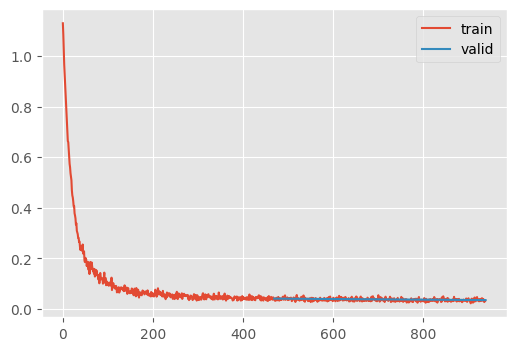

In [10]:
unet = fashion_unet()
ddpm = train(unet)

To denoise, we need to reverse the noisification. Recall, for a given sample $x_0$, the noised sample is defined as:
    x_t = ᾱ_t.sqrt() * x_0 + (1 - ᾱ_t).sqrt() * ε
$$
x_t = \sqrt{ \bar{\alpha}_t } x_0 + \left( \sqrt{ 1 - \bar{\alpha}_t } \right) \epsilon
$$

Thus,

$$
x_0 = \frac{ x_t - \left( \sqrt{ 1 - \bar{\alpha}_t } \right) \epsilon }{ \sqrt{ \bar{\alpha}_t } }
$$

In [11]:
def denoisify(x_t, noise, t):
    ᾱ_t = ᾱ(t).reshape(-1, 1, 1, 1)
    return (x_t - (1 - ᾱ_t).sqrt() * noise) / ᾱ_t.sqrt()

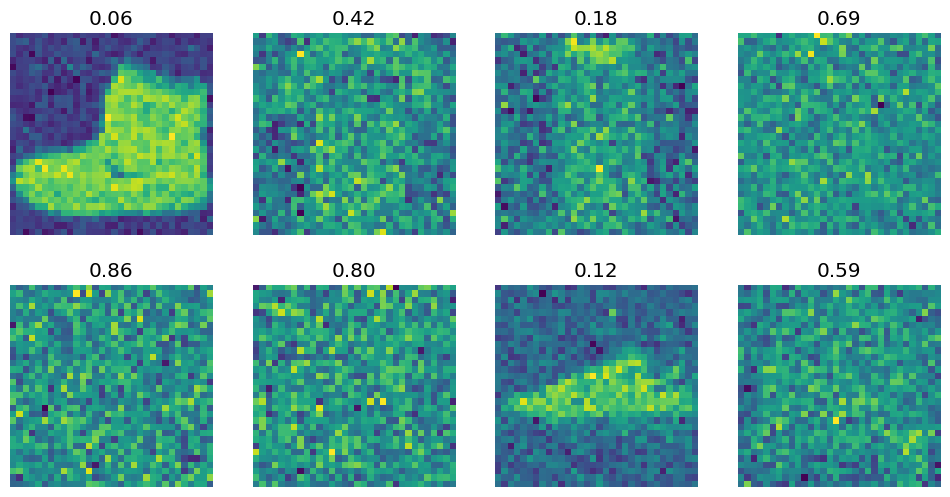

In [12]:
(x_t, ts), eps = noisify(xb)
show_images(x_t[:8], titles=[f"{t.item():.2f}" for t in ts[:8]])

This looks impressive for one step, but recall `xb` is part of the training data.

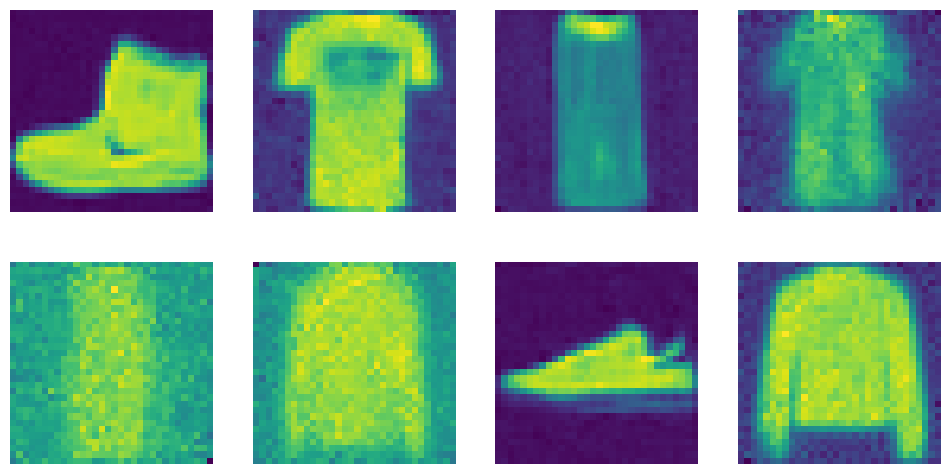

In [13]:
eps_pred = unet(x_t.to(def_device), ts.to(def_device)).sample
x_0 = denoisify(x_t, eps_pred.cpu(), ts)
show_images(x_0[:8])

Finally, we can rewrite the sampling algorithm without any $\alpha$s or $\beta$s.

In [14]:
@torch.no_grad()
def sample(self, model, sz=(16, 1, 32, 32), device=def_device, n_steps=100):
    x_t = torch.randn(sz, device=device)
    ts = torch.linspace(1 - (1 / n_steps), 0, n_steps).to(device)
    for t, t_next in tqdm(zip(ts, ts[1:]), unit="time step", total=n_steps - 1):
        # Predict the noise for each example in the image
        noise_pred = model(x_t, t).sample

        # Predict the image without noise
        x_0_pred = denoisify(x_t, noise_pred, t)

        # Renoise
        (x_t_minus_1, _), _ = noisify(x_0_pred, t_next)

        # Repeat
        x_t = x_t_minus_1

    # At the last step, simply rescale and do not add noise
    t = tensor(0.0, device=device)
    x_0 = denoisify(x_t, model(x_t, t).sample, t)

    return x_t


DDPM.sample = sample

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 68.04time step/s]


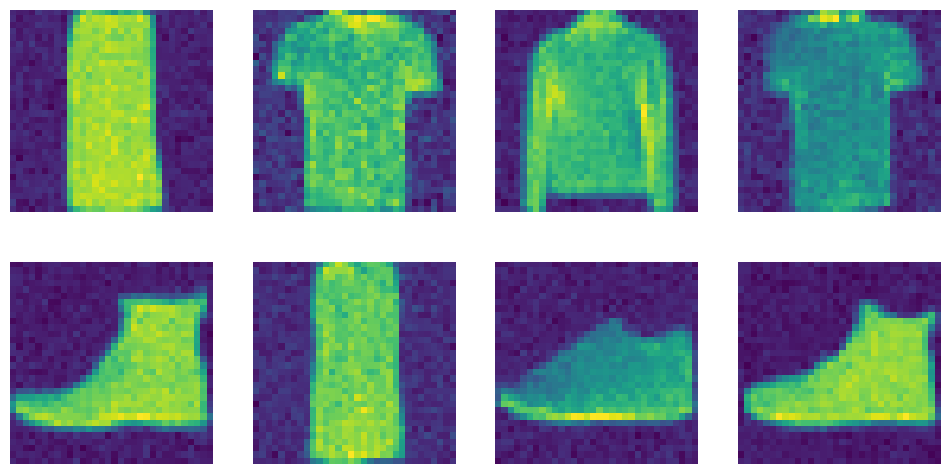

In [15]:
x_0 = ddpm.sample(unet, sz=(8, 1, 32, 32), n_steps=100)
show_images(x_0)

This code had a few bugs in it initially that led to deep-fried results.

- `denoisify` was given `torch.randn` instead of `noise_pred`
- The last denoising iteration was given `t=1` instead of `t=0`

In [17]:
#| hide
import nbdev

nbdev.nbdev_export()